# Import dependencies

In [34]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from matplotlib import pyplot as plt
%matplotlib inline

# Loading data

In [36]:
train = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')

In [37]:
train.shape, test.shape

((891, 12), (418, 11))

In [38]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [39]:
y_train = train['Survived']

In [40]:
x_train = train.drop(['Survived'], axis = 1)

In [41]:
x_train.shape, y_train.shape, x_train.columns

((891, 11),
 (891,),
 Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
        'Ticket', 'Fare', 'Cabin', 'Embarked'],
       dtype='object'))

## Imbalanced dataset

In [42]:
y_train.value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

# Pre-processing and exploring the dataset

In [43]:
x_train.head(10)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [44]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Pclass       891 non-null    int64  
 2   Name         891 non-null    object 
 3   Sex          891 non-null    object 
 4   Age          714 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Ticket       891 non-null    object 
 8   Fare         891 non-null    float64
 9   Cabin        204 non-null    object 
 10  Embarked     889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 76.7+ KB


In [45]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [46]:
#x_train['Parch'].value_counts()
#x_train['SibSp'].value_counts()
x_train['Embarked'].value_counts()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

In [47]:
#test['Parch'].value_counts()
#test['SibSp'].value_counts()
test['Embarked'].value_counts()

Embarked
S    270
C    102
Q     46
Name: count, dtype: int64

In [48]:
#passenger_train = x_train['PassengerId']
x_train.drop(['PassengerId','Ticket','Cabin','Name'], axis = 1, inplace = True)
passenger_test = test['PassengerId']
test.drop(['PassengerId','Ticket','Cabin','Name'], axis = 1, inplace = True)

In [49]:
x_train.describe()

,Pclass,Age,SibSp,Parch,Fare
count,891.000000,714.000000,891.000000,891.000000,891.000000
mean,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.420000,0.000000,0.000000,0.000000
25%,2.000000,20.125000,0.000000,0.000000,7.910400
50%,3.000000,28.000000,0.000000,0.000000,14.454200
75%,3.000000,38.000000,1.000000,0.000000,31.000000
max,3.000000,80.000000,8.000000,6.000000,512.329200


In [50]:
test.describe()

,Pclass,Age,SibSp,Parch,Fare
count,418.000000,332.000000,418.000000,418.000000,417.000000
mean,2.265550,30.272590,0.447368,0.392344,35.627188
std,0.841838,14.181209,0.896760,0.981429,55.907576
min,1.000000,0.170000,0.000000,0.000000,0.000000
25%,1.000000,21.000000,0.000000,0.000000,7.895800
50%,3.000000,27.000000,0.000000,0.000000,14.454200
75%,3.000000,39.000000,1.000000,0.000000,31.500000
max,3.000000,76.000000,8.000000,9.000000,512.329200


In [51]:
mean_age_train = x_train['Age'].mean()
mean_age_test = test['Age'].mean()

In [52]:
mean_age_train, mean_age_test

(29.69911764705882, 30.272590361445783)

In [53]:
x_train.fillna(mean_age_train,inplace = True)
test.fillna(mean_age_test,inplace = True)

In [54]:
x_train['Sex'] = [0 if x == 'female' else 1 for x in x_train['Sex']]
test['Sex'] = [0 if x == 'female' else 1 for x in test['Sex']]

In [55]:
x_train['Embarked'] = [0 if x == 'S' else 1 if x == 'C' else 2 for x in x_train['Embarked']]
test['Embarked'] = [0 if x == 'S' else 1 if x == 'C' else 2 for x in test['Embarked']]

In [56]:
x_train.shape, test.shape

((891, 7), (418, 7))

In [57]:
x_train.head(10)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,1,22.000000,1,0,7.2500,0
1,1,0,38.000000,1,0,71.2833,1
2,3,0,26.000000,0,0,7.9250,0
3,1,0,35.000000,1,0,53.1000,0
4,3,1,35.000000,0,0,8.0500,0
5,3,1,29.699118,0,0,8.4583,2
6,1,1,54.000000,0,0,51.8625,0
7,3,1,2.000000,3,1,21.0750,0
8,3,0,27.000000,0,2,11.1333,0
9,2,0,14.000000,1,0,30.0708,1


In [58]:
test.head(10)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,1,34.5,0,0,7.8292,2
1,3,0,47.0,1,0,7.0000,0
2,2,1,62.0,0,0,9.6875,2
3,3,1,27.0,0,0,8.6625,0
4,3,0,22.0,1,1,12.2875,0
5,3,1,14.0,0,0,9.2250,0
6,3,0,30.0,0,0,7.6292,2
7,2,1,26.0,1,1,29.0000,0
8,3,0,18.0,0,0,7.2292,1
9,3,1,21.0,2,0,24.1500,0


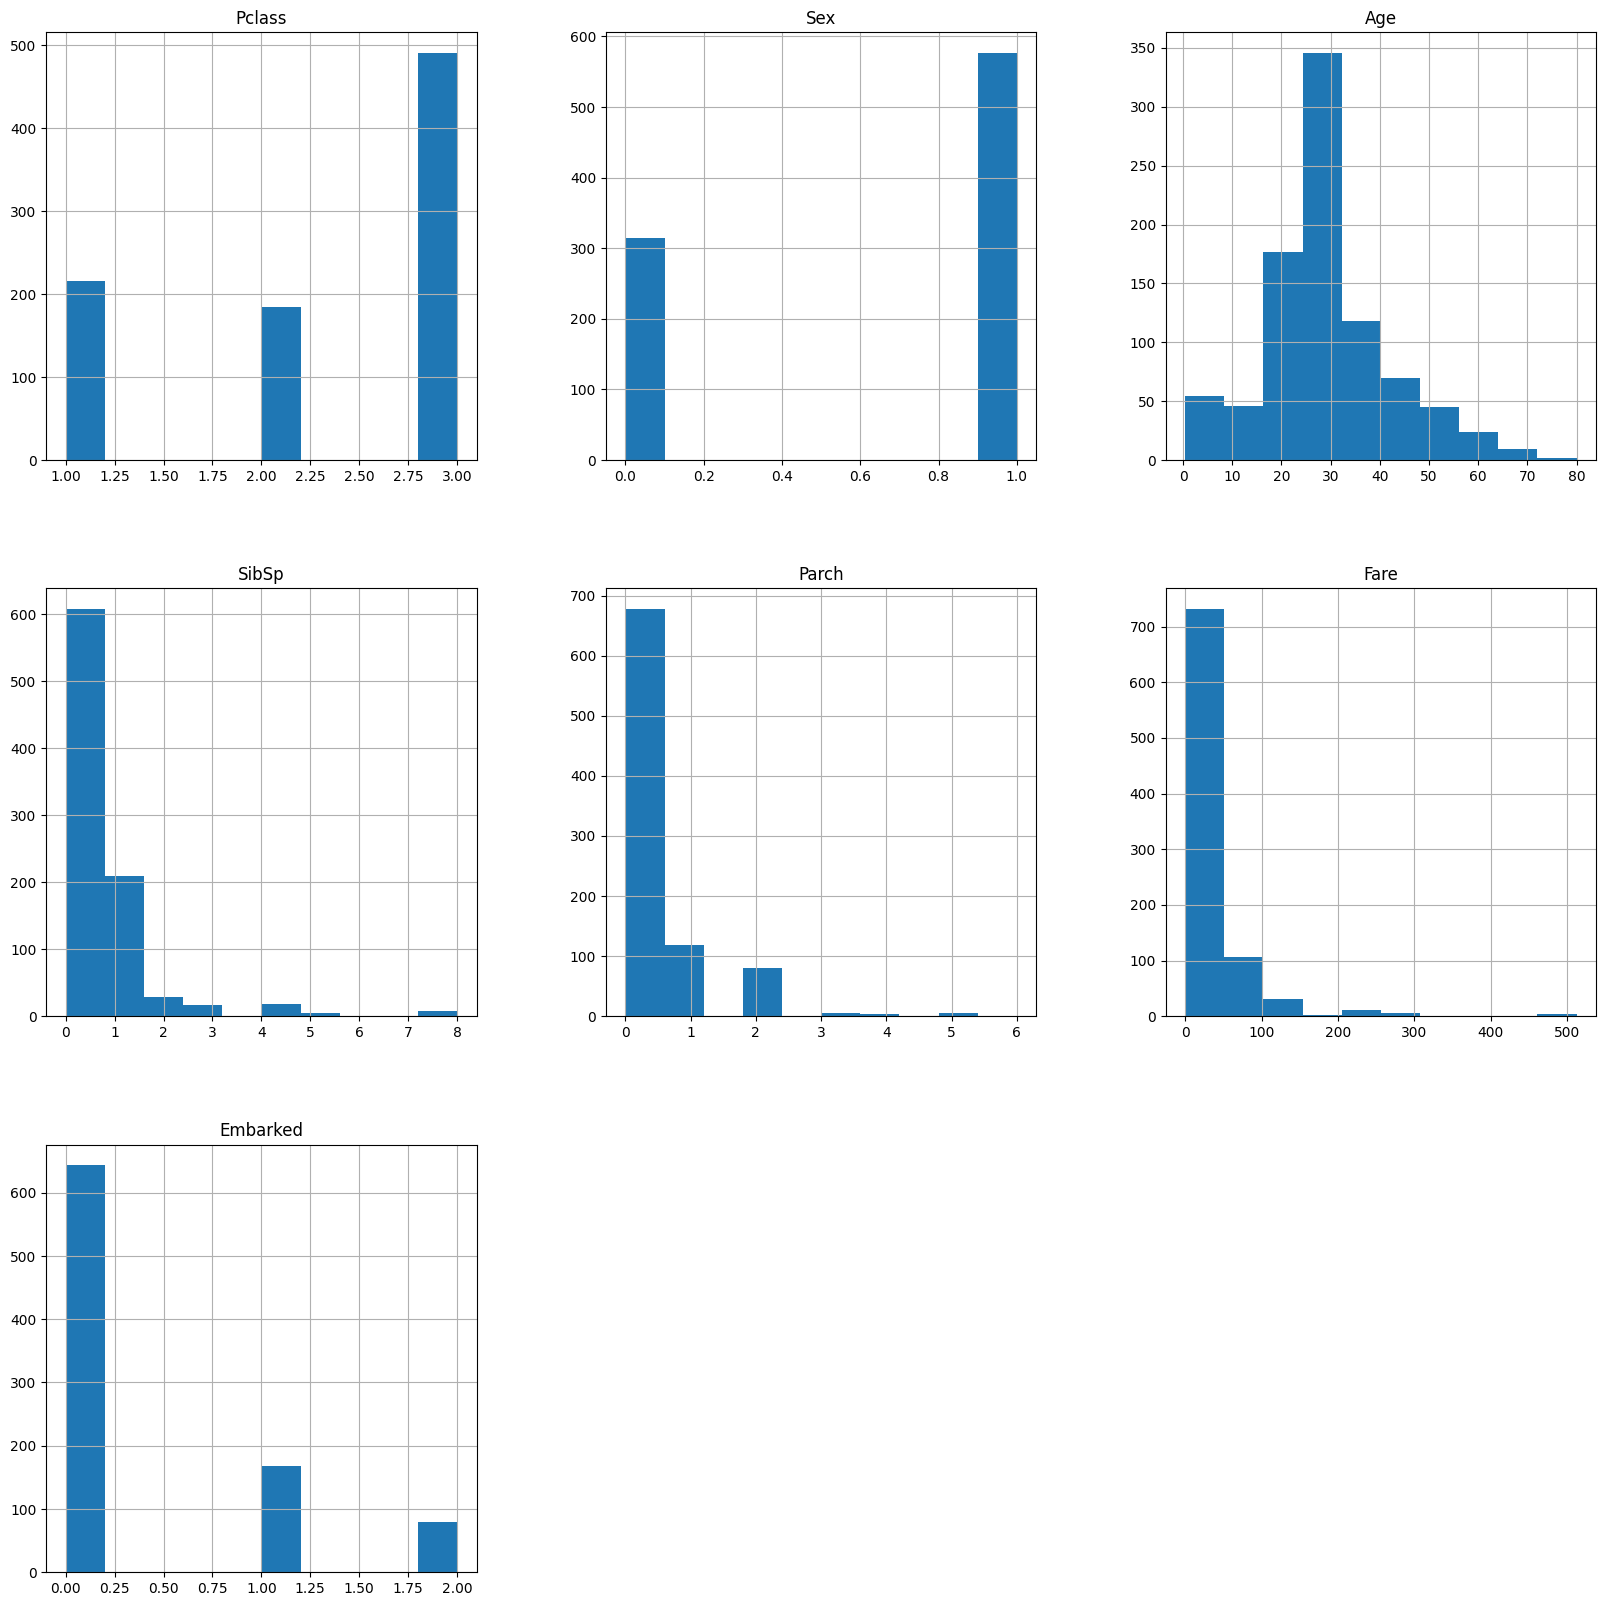

In [59]:
%matplotlib inline
import matplotlib.pyplot as plt
x_train.hist(figsize=(20, 20))
plt.show()

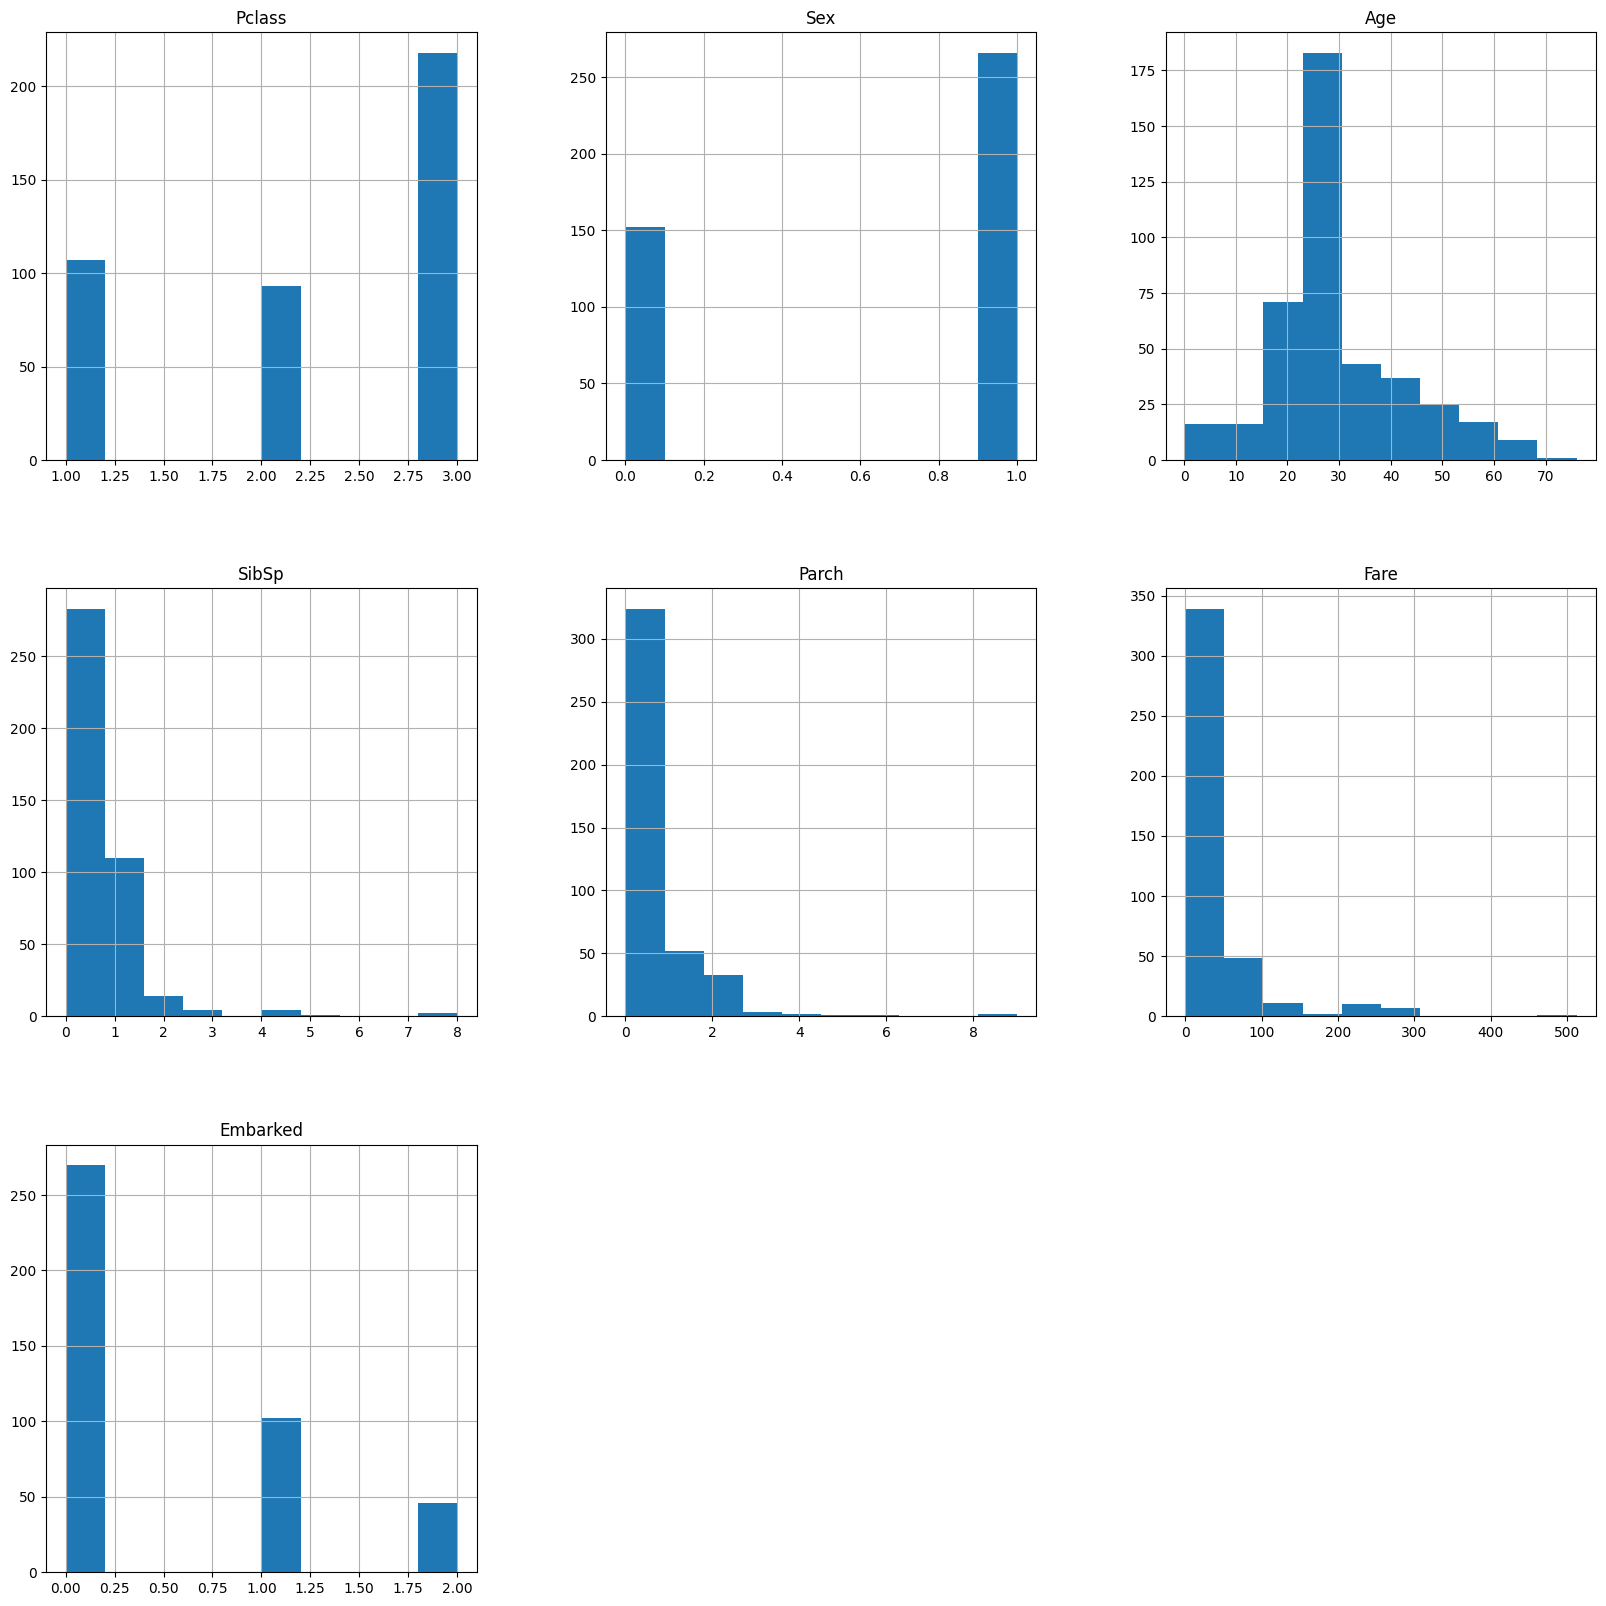

In [60]:
%matplotlib inline
import matplotlib.pyplot as plt
test.hist(figsize=(20, 20))
plt.show()

# Standardize the dataset

In [61]:
x_train.shape, test.shape

((891, 7), (418, 7))

In [62]:
duplicates = [i for i in range(x_train.duplicated().shape[0]) if x_train.duplicated()[i] == True]

In [63]:
x_train.drop(duplicates, inplace = True), y_train.drop(duplicates, inplace = True)

(None, None)

In [64]:
x_train.shape, y_train.shape

((764, 7), (764,))

In [65]:
parameters = StandardScaler()
parameters.fit(x_train)

StandardScaler()

In [66]:
standardized_x_train = parameters.transform(x_train) 
standardized_test = parameters.transform(test)

In [67]:
y_train = np.array(y_train)

# Classifying

In [ ]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(standardized_x_train, y_train)

y_pred = xgb_model.predict(standardized_x_train)

print(accuracy_score(y_train, y_pred))
print(recall_score(y_train, y_pred))
print(precision_score(y_train, y_pred))

In [ ]:
xgb_model2 = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model2_scores = cross_val_score(xgb_model2, standardized_x_train, y_train.ravel(), cv=5)
print(xgb_model2_scores)

# Saving predictions of the model on the test set

In [ ]:
y_pred = xgb_model.predict(standardized_test)

In [ ]:
predictions = pd.DataFrame(passenger_test,columns=['PassengerId'])

In [ ]:
predictions['Survived'] = y_pred

In [ ]:
predictions.to_csv('submission.csv', index = False)